In [1]:
%%capture
from google.colab import drive
drive.mount("/content/drive")
%cd /content/drive/MyDrive/nyu-stuff/2023-fall/DS-UA\ 301\ Advanced\ DS/final_project

%pip install -r requirements.txt
%pip install wandb -Uq

In [2]:
import pandas
import numpy
import json5
import functools
import json
from matplotlib import pyplot
from typing import Optional, Any, Coroutine, Union, Dict, List
import nltk
from nltk.corpus import stopwords
import string
import contractions
import torch
import wandb
import sklearn
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

nltk.download("averaged_perceptron_tagger")
nltk.download("universal_tagset")
nltk.download("stopwords")
nltk.download("punkt")

def get_best_torch_device():
    if torch.cuda.is_available():  # CUDA
        return "cuda"
    elif torch.backends.mps.is_available():  # Apple Silicon / GPU
        return "mps"
    else:  # Fallback to CPU
        return "cpu"

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Configure hyperparameters (+ random state)
random_state = 13117

device = get_best_torch_device()
print(f"Currently using {device.upper()} for training!")

Currently using CUDA for training!


In [7]:
!ls -als data/

total 442089
 45402 -rw------- 1 root root  46491149 Nov  3 20:17 amazon_reviews.zip
 20421 -rw------- 1 root root  20910546 Nov  7 03:30 balanced_data.csv
 24743 -rw------- 1 root root  25335945 Nov  9 04:47 balanced_with_labels.csv
 44895 -rw------- 1 root root  45972134 Dec  2 10:22 balanced_with_labels_v2.csv
138370 -rw------- 1 root root 141690237 Oct 16 22:26 Cell_Phones_and_Accessories_5.json
     4 drwx------ 2 root root      4096 Nov 29 23:31 checkpoints
 95424 -rw------- 1 root root  97713795 Nov  6 21:40 cleaned_data.csv
     4 drwx------ 2 root root      4096 Dec  2 06:56 .ipynb_checkpoints
 24768 -rw------- 1 root root  25362418 Nov  7 06:04 labels.csv
 44310 -rw------- 1 root root  45372886 Dec  2 10:22 labels_v2.csv
     4 drwx------ 2 root root      4096 Dec  2 06:50 label_temp
  1297 -rw------- 1 root root   1327715 Dec  2 17:28 sweep_result_loss_mp_fast_final_2.pickle
  1205 -rw------- 1 root root   1233520 Dec  6 20:34 sweep_result_loss_mp_fast_final_4.pickle
     1 

In [12]:
trained_models = torch.load(
    "data/sweep_result_loss_mp_fast_final_4.pickle",
    map_location=torch.device(get_best_torch_device())
  )

In [13]:
len(trained_models)

32

In [14]:
trained_models_sorted = dict(sorted(trained_models.items()))

In [15]:
print(
    "Here are the losses from trained combinations in increasing order:\n",
    "\n\t".join([] + list([str(key) for key in trained_models_sorted.keys()])),
)

Here are the losses from trained combinations in increasing order:
 0.8501313328742981
	0.9278983473777771
	0.9413906335830688
	0.9618238210678101
	0.9699496626853943
	0.9725909233093262
	0.9883692264556885
	0.9928133487701416
	0.9946361780166626
	0.9954305291175842
	1.0004295110702515
	1.0081853866577148
	1.0132942199707031
	1.0187288522720337
	1.0538749694824219
	1.0636355876922607
	1.0675654411315918
	1.070512056350708
	1.0829776525497437
	1.0952571630477905
	1.1093000173568726
	1.628320336341858
	1.6868677139282227
	1.7017772197723389
	1.76595938205719
	1.7798349857330322
	1.8767749071121216
	1.9522030353546143
	1.9590808153152466
	2.3600542545318604
	2.4340832233428955
	2.485626220703125


In [16]:
keys = list(trained_models_sorted.keys())
props_best = trained_models[keys[0]]

In [17]:
print("The model with best results is using the following hyperparameters:")

for k, v in props_best["config"].items():
    print(f"\t{k}: {v}")

print("Which yields the following results: ")

for k, v in props_best.items():
    if k in ["result_df", "chkpt", "config"]:
        continue

    print(f"\t{k}: {v}")

The model with best results is using the following hyperparameters:
	activation_func: relu
	batch_size: 8192
	is_batch_norm: True
	learning_rate: 0.1
	n_epochs: 128
	n_layers: 4
	optimizer: adam
Which yields the following results: 
	val_loss: 0.8501313328742981
	val_acc: 0.6108333333333333
	train_acc: 0.611


,epoch,train_loss,val_loss,val_accuracy,train_accuracy
0,0,2.302621,17.045561,0.358167,0.353857
1,1,1.673386,8.230606,0.468500,0.469393
2,2,1.426529,4.230173,0.479500,0.479857
3,3,1.273277,2.947084,0.529167,0.527393
4,4,1.189890,2.267007,0.570500,0.571036
...,...,...,...,...,...
123,123,0.872396,0.858074,0.613667,0.614357
124,124,0.860965,0.859910,0.605000,0.608929
125,125,0.904576,0.863072,0.610667,0.610071
126,126,0.867033,0.875176,0.581000,0.586000


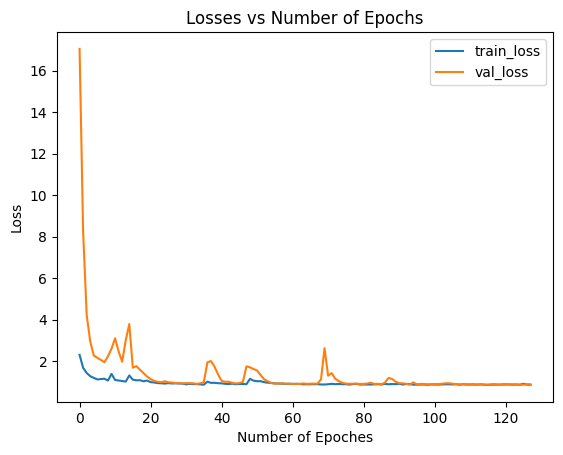

In [23]:
df_results = props_best["result_df"]

display(df_results)

# train_loss and val_loss vs epoch
pyplot.plot(df_results["train_loss"], label="train_loss")
pyplot.plot(df_results["val_loss"], label="val_loss")
pyplot.xlabel("Number of Epoches")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.title(f"Losses vs Number of Epochs")
pyplot.show()

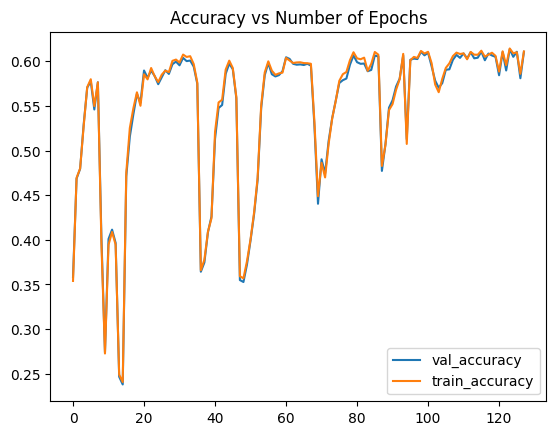

In [22]:
pyplot.plot(df_results["val_accuracy"], label="val_accuracy")
pyplot.plot(df_results["train_accuracy"], label="train_accuracy")
pyplot.title(f"Accuracy vs Number of Epochs")
pyplot.legend()
pyplot.show()

In [24]:
columns = list(
    set(
        list(props_best["config"].keys())  # Weights and Biases config
        + [
            k for k in props_best.keys() if k not in ["config", "result_df", "chkpt"]
        ]  # telemetry data
        + ["best_epoch", "train_loss"]  # Internal telemetry data
    )
)

In [25]:
rows = []

for k, v in trained_models_sorted.items():
    values = {}

    for key, value in v.items():
        if key in columns:
            values[key] = value

    for key, value in v["config"].items():
        if key in columns:
            values[key] = value

    values["best_epoch"] = v["chkpt"]["epoch"]
    values["train_loss"] = (v["chkpt"]["loss"]).cpu().detach().numpy()

    val_arr = [values[key] for key in columns]
    rows.append(val_arr)

df_stats = pandas.DataFrame(columns=columns, data=rows)

In [26]:
df_stats

,optimizer,n_epochs,n_layers,val_acc,activation_func,train_loss,val_loss,is_batch_norm,best_epoch,train_acc,batch_size,learning_rate
0,adam,128,4,0.610833,relu,0.8533642,0.850131,True,115,0.611000,8192,0.100
1,adam,128,2,0.595000,leaky_relu,0.9481484,0.927898,True,126,0.597714,4096,0.010
2,adam,128,2,0.592333,leaky_relu,0.95796496,0.941391,True,127,0.595321,4096,0.010
3,adam,128,4,0.608333,relu,0.97419935,0.961824,True,124,0.612714,8192,0.010
4,adam,128,4,0.604667,relu,1.0101215,0.969950,True,124,0.595107,4096,0.005
5,adam,128,3,0.613167,relu,1.0082763,0.972591,True,127,0.612893,4096,0.005
6,adam,128,3,0.612333,relu,1.0055758,0.988369,True,127,0.612143,8192,0.010
7,sgd,128,4,0.610000,relu,1.0103582,0.992813,True,118,0.613679,8192,0.100
8,sgd,128,2,0.566500,leaky_relu,1.0299276,0.994636,True,120,0.558679,4096,0.100
9,sgd,128,4,0.601167,leaky_relu,0.9980342,0.995431,True,126,0.596036,8192,0.100


In [27]:
df_stats.describe()

,n_epochs,n_layers,val_acc,val_loss,best_epoch,train_acc,batch_size,learning_rate
count,32.0,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000,32.000000
mean,128.0,2.937500,0.558302,1.337793,122.500000,0.554638,6784.000000,0.030937
std,0.0,0.840027,0.089806,0.498083,5.611049,0.092826,1976.560453,0.040569
min,128.0,2.000000,0.222333,0.850131,105.000000,0.237571,4096.000000,0.005000
25%,128.0,2.000000,0.566125,0.994180,120.000000,0.556830,4096.000000,0.005000
50%,128.0,3.000000,0.594333,1.065601,124.500000,0.595679,8192.000000,0.010000
75%,128.0,4.000000,0.607583,1.717823,127.000000,0.603071,8192.000000,0.032500
max,128.0,4.000000,0.613167,2.485626,127.000000,0.613679,8192.000000,0.100000


In [ ]:
# good_keys = df_not_overfit["val_loss"].tolist()
# good_model_1 = trained_models[good_keys[0]]

In [31]:
def describe_model(model_info, name: str = ""):
    print(f"The model {name} is using the following hyperparameters:")

    for k, v in model_info["config"].items():
        print(f"\t{k}: {v}")

    print("Which yields the following results: ")

    for k, v in model_info.items():
        if k in ["result_df", "chkpt", "config"]:
            continue

        print(f"\t{k}: {v}")

    df_results = model_info["result_df"]

    # train_loss and val_loss vs epoch
    pyplot.plot(df_results["train_loss"], label="train_loss")
    pyplot.plot(df_results["val_loss"], label="val_loss")
    pyplot.xlabel("Number of Epoches")
    pyplot.ylabel("Loss")
    pyplot.legend()
    pyplot.title(f"Losses vs Number of Epochs ({name})")
    pyplot.show()

    pyplot.plot(df_results["val_accuracy"], label="val_accuracy")
    pyplot.plot(df_results["train_accuracy"], label="train_accuracy")
    pyplot.title(f"Accuracy vs Number of Epochs")
    pyplot.legend()
    pyplot.show()

The model good_model_1 is using the following hyperparameters:
	activation_func: relu
	batch_size: 8192
	is_batch_norm: True
	learning_rate: 0.1
	n_epochs: 128
	n_layers: 4
	optimizer: adam
Which yields the following results: 
	val_loss: 0.8501313328742981
	val_acc: 0.6108333333333333
	train_acc: 0.611


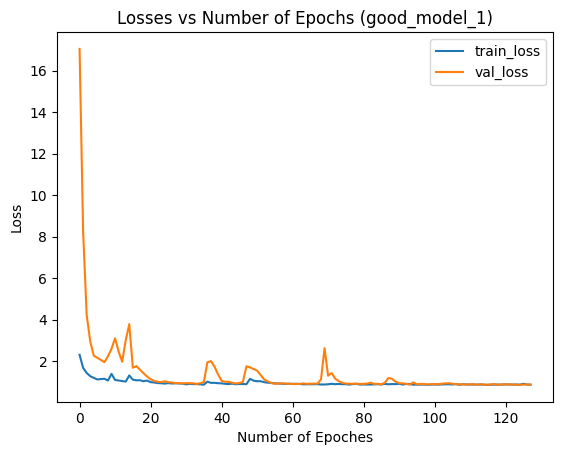

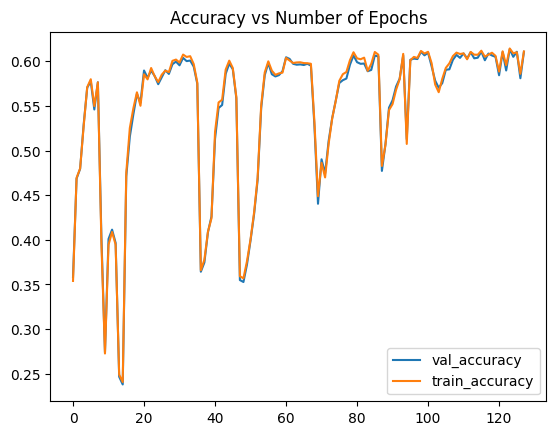

In [32]:
describe_model(props_best, "good_model_1")

In [35]:
class FairDataset(torch.utils.data.Dataset):
    def __init__(self, df_input):
        df_x = df_input[
            [
                c
                for c in df_input.columns
                if c not in ["review_text", "rating", "length"]
            ]
        ]
        df_y = df_input["rating"]
        self.features = torch.tensor(df_x.values, dtype=torch.float32).to(device)
        self.labels = torch.tensor(df_y.values, dtype=torch.float32).to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

def spawn_layers(
    n_layers,
    input_size,
    output_size,
    is_batch_norm=True,
    activation_func=nn.ReLU,
    output_func=nn.LogSoftmax,
):
    layers = []
    prev_hidden = input_size

    for i in range(n_layers):
        hidden_size = int((prev_hidden + output_size) / 2)

        layers += [
            nn.Linear(in_features=prev_hidden, out_features=hidden_size),
            nn.BatchNorm1d(hidden_size) if is_batch_norm else nn.Identity(),
            activation_func(),
        ]

        prev_hidden = hidden_size

    return layers + [output_func(dim=1)]

# Spawns a model we trained
def spawn_model(props):


    chkpt = props["chkpt"]

    params = chkpt["params"]

    batch_size = params["batch_size"]
    n_layers = params["n_layers"]
    learning_rate = params["learning_rate"]
    n_epochs = params["n_epochs"]
    is_batch_norm = params["is_batch_norm"]
    input_size = len(chkpt["input_columns"])
    output_size = 1

    optimizer_func = (
        torch.optim.Adam if params["optimizer"] == "adam" else torch.optim.SGD
    )
    activation_func = (
        nn.LeakyReLU if params["activation_func"] == "leaky_relu" else nn.ReLU
    )

    model = nn.Sequential(
        *spawn_layers(
            n_layers,
            input_size,
            output_size,
            activation_func=activation_func,
            is_batch_norm=is_batch_norm,
        )
    ).to(get_best_torch_device())

    model.load_state_dict(chkpt["model_state_dict"])
    model.eval()

    return model

In [37]:
spwanned_model = spawn_model({
    "chkpt" : torch.load("data/best_chkpt_final_4.pickle", map_location=torch.device(get_best_torch_device()))
})

RuntimeError: ignored